### 0.0 Importações e Bibliotecas

In [2]:
import inflection

import numpy               as np
import pandas              as pd
import seaborn             as sns

from sklearn               import ensemble        as en
from sklearn               import model_selection as ms

from scipy                 import stats
from sklearn               import metrics
from xgboost               import XGBClassifier
from lightgbm              import LGBMClassifier
from sklearn.tree          import DecisionTreeClassifier
from dython.nominal        import associations
from sklearn.ensemble      import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors     import KNeighborsClassifier
from category_encoders     import target_encoder
from sklearn.naive_bayes   import GaussianNB
from sklearn.linear_model  import LogisticRegression
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, StandardScaler

#### 0.1 Load Data

In [3]:
train_raw = pd.read_csv('csv_files/train.csv')
test_raw = pd.read_csv('csv_files/test.csv')

In [4]:
# Train_raw = train_raw.dropna()

X = train_raw.drop('Reserva Cancelada', axis=1)
y = train_raw['Reserva Cancelada'].copy()

# Split data into train and test
x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.20, random_state=42)

df1 = pd.concat([x_train, y_train], axis=1)

#### 0.2 Functions

In [5]:
sns.set(rc={'figure.figsize':(20, 10)})

# Cramer's V -> fórmula para se medir a correlação de variáveis categóricas simetricamente
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


# Theil's U -> fórmula para se medir a correlação de variáveis categóricas simetricamente
def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

### 1.0 Descrição dos dados

#### 1.1 Rename Columns

In [6]:
old_cols = df1.columns
snakecase = lambda x : inflection.parameterize(x, separator='_')
cols = list(map(snakecase, old_cols))
df1.columns = cols

old_cols = x_test.columns
snakecase = lambda x : inflection.parameterize(x, separator='_')
cols = list(map(snakecase, old_cols))
x_test.columns = cols

old_cols = test_raw.columns
snakecase = lambda x : inflection.parameterize(x, separator='_')
cols = list(map(snakecase, old_cols))
test_raw.columns = cols

#### 1.2 Data Dimension

In [7]:
df1.shape

(57727, 15)

#### 1.3 Data Types

In [8]:
df1.dtypes

id                                        int64
classificacao_do_hotel                   object
meses_da_reserva_ate_o_check-in           int64
numero_de_pernoites_reservadas            int64
numero_de_hospedes                      float64
regime_de_alimentacao                    object
nacionalidade                            object
forma_de_reserva                         object
ja_se_hospedou_anterioremente            object
tipo_do_quarto_reservado                 object
reserva_feita_por_agencia_de_turismo     object
reserva_feita_por_empresa                object
reserva_com_estacionamento               object
reserva_com_observacoes                  object
reserva_cancelada                         int64
dtype: object

#### 1.4 Check NA

In [9]:
df1.isna().sum()

id                                        0
classificacao_do_hotel                    0
meses_da_reserva_ate_o_check-in           0
numero_de_pernoites_reservadas            0
numero_de_hospedes                        2
regime_de_alimentacao                     0
nacionalidade                           887
forma_de_reserva                          0
ja_se_hospedou_anterioremente             0
tipo_do_quarto_reservado                  0
reserva_feita_por_agencia_de_turismo      0
reserva_feita_por_empresa                 0
reserva_com_estacionamento                0
reserva_com_observacoes                   0
reserva_cancelada                         0
dtype: int64

#### 1.5 Descriptive Statistical

In [10]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
id,57727.0,60037.392329,34755.892455,1.0,29909.0,59977.0,90312.5,120261.0
meses_da_reserva_ate_o_check-in,57727.0,7.210214,26.105933,1.0,1.0,3.0,6.0,311.0
numero_de_pernoites_reservadas,57727.0,15.780865,97.536366,0.0,2.0,3.0,4.0,1172.0
numero_de_hospedes,57725.0,14.134067,96.052925,0.0,2.0,2.0,2.0,1153.0
reserva_cancelada,57727.0,0.371507,0.483212,0.0,0.0,0.0,1.0,1.0


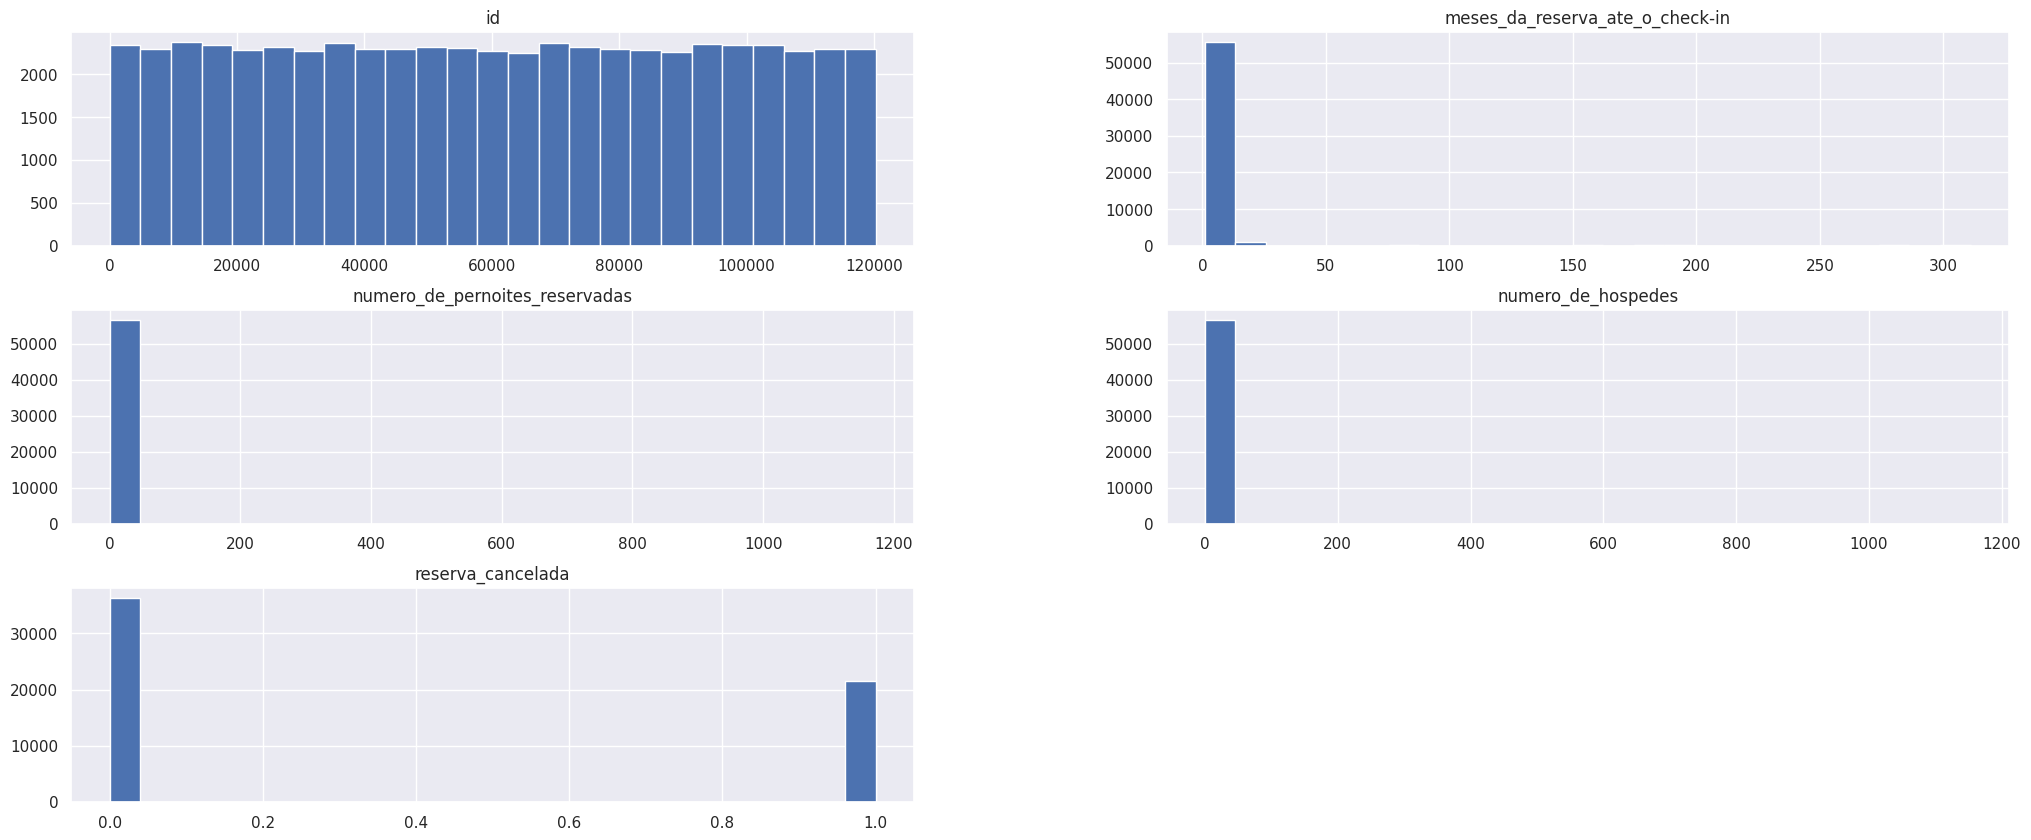

In [11]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
num_attributes.hist(bins=25, figsize=(25, 10));

In [12]:
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
d3 = pd.concat([d1, d2]).T.reset_index()
d3.columns = ['attributes', 'skew', 'kurtosis']
d3

,attributes,skew,kurtosis
0,id,0.001744,-1.204242
1,meses_da_reserva_ate_o_check-in,8.597700,78.334177
2,numero_de_pernoites_reservadas,8.762338,80.347931
3,numero_de_hospedes,8.771617,80.547922
4,reserva_cancelada,0.531846,-1.717199


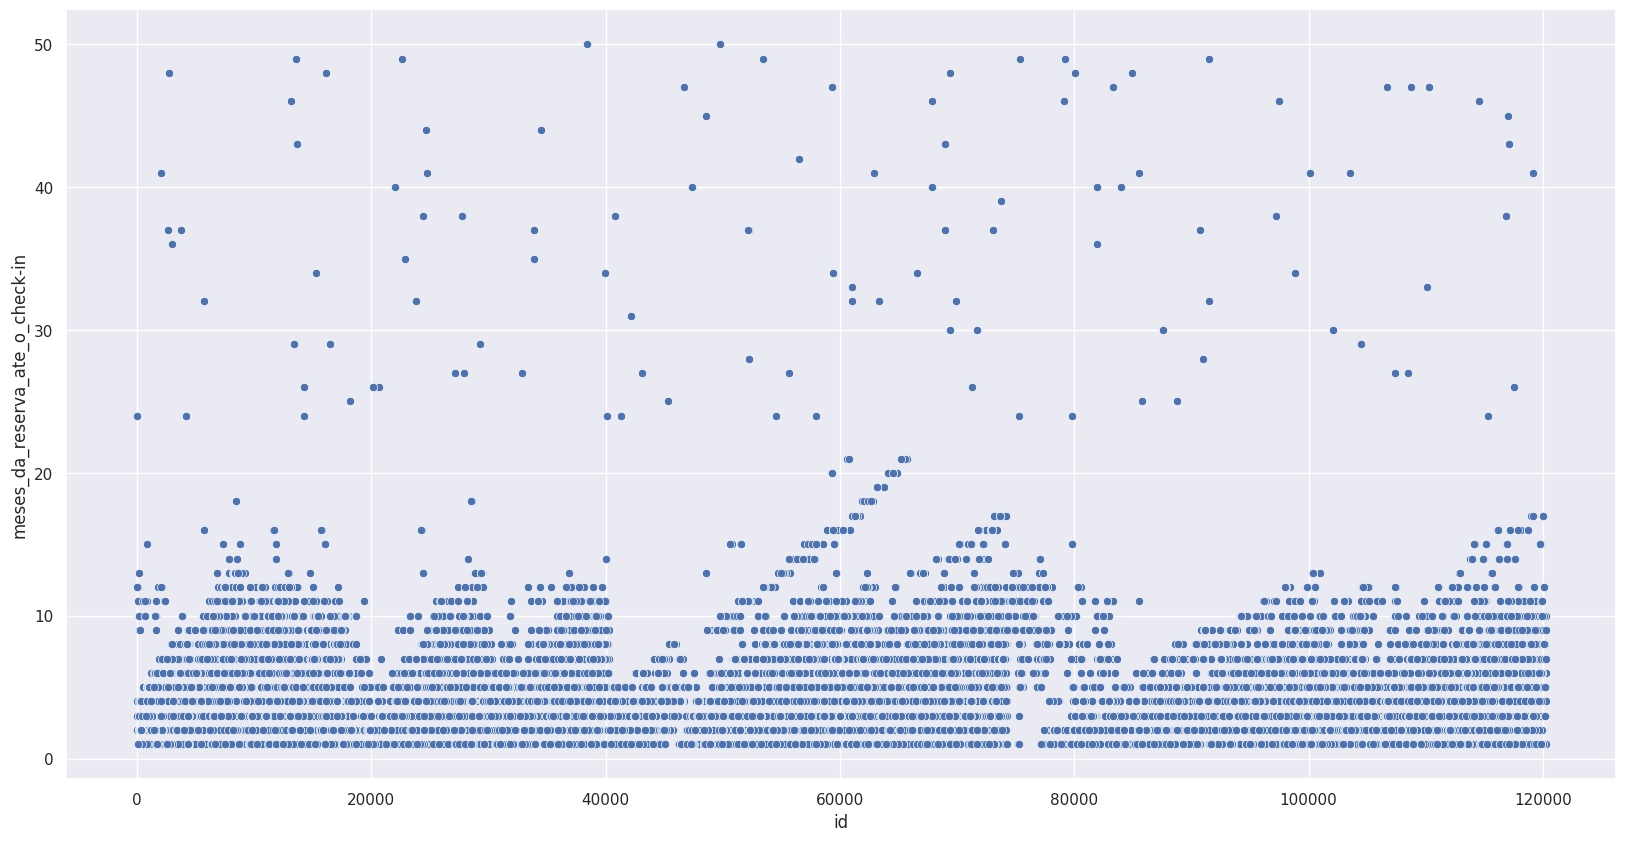

In [13]:
aux = df1.loc[df1['meses_da_reserva_ate_o_check-in'] <= 50]
sns.scatterplot(data=aux, x='id', y='meses_da_reserva_ate_o_check-in');

### 2.0 Feature Engineering

In [14]:
df2 = df1.copy()

#### 2.1 Hipóteses

#### 2.2 Feature Engineering

In [15]:
# plt.subplot(1, 3, 1)
# aux1 = df2['meses_da_reserva_ate_o_check-in']
# sns.boxplot(data=aux1)

# plt.subplot(1, 3, 2)
# aux2 = df2['numero_de_pernoites_reservadas']
# sns.boxplot(data=aux2)

# plt.subplot(1, 3, 3)
# aux3 = df2['numero_de_hospedes']
# sns.boxplot(data=aux3);

In [16]:
# Ajustando os valores tidos como 'outliers' da coluna 'meses_da_reserva_ate_o_check - in'
#df2['meses_da_reserva_ate_o_check-in'] = df2['meses_da_reserva_ate_o_check-in'].apply(lambda x: 15 if x >= 7 else x)

# Ajustando os valores tidos como 'outliers' da coluna 'numero_de_pernoites_reservadas'
#df2['numero_de_pernoites_reservadas'] = df2['numero_de_pernoites_reservadas'].apply(lambda x: 12 if x >= 5 else x)

# # Ajustando os valores tidos como 'outliers' da coluna 'numero_de_hospedes'
# df2['numero_de_hospedes'] = df2['numero_de_hospedes'].apply(lambda x: 4 if x >= 3 else x)

In [17]:
# Train data

median_number_customers = df2['numero_de_hospedes'].median()

df2['numero_de_hospedes'].fillna(median_number_customers, inplace=True)
df2['numero_de_hospedes'] = df2['numero_de_hospedes'].apply(lambda x: 2 if x >= 3 else x)
df2['nacionalidade'].fillna('Desconhecido', inplace=True)


# Test data
x_test['numero_de_hospedes'].fillna(median_number_customers, inplace=True)
x_test['numero_de_hospedes'] = x_test['numero_de_hospedes'].apply(lambda x: 2 if x >= 3 else x)
x_test['nacionalidade'].fillna('Desconhecido', inplace=True)

# Validation data
test_raw['numero_de_hospedes'].fillna(median_number_customers, inplace=True)
test_raw['numero_de_hospedes'] = test_raw['numero_de_hospedes'].apply(lambda x: 2 if x >= 3 else x)
test_raw['nacionalidade'].fillna('Desconhecido', inplace=True)

In [18]:
# Ajuste dos valores de pernoites reservadas

# df2['numero_de_pernoites_reservadas'] = df2['numero_de_pernoites_reservadas'].apply(lambda x: 15 if x >= 16 else x)

# x_test['numero_de_pernoites_reservadas'] = x_test['numero_de_pernoites_reservadas'].apply(lambda x: 15 if x >= 16 else x)

# test_raw['numero_de_pernoites_reservadas'] = test_raw['numero_de_pernoites_reservadas'].apply(lambda x: 15 if x >= 16 else x)

In [19]:
# Classificação dos quartos em estrelas, tirando a média das estrelas 

df2['classificacao_do_hotel_2'] = df2['classificacao_do_hotel'].apply(lambda x: 4 if x == '4 estrelas' else 5)
estrelas_quarto_map = df2.groupby(['tipo_do_quarto_reservado'])['classificacao_do_hotel_2'].mean()
df2['estrelas_quarto'] = df2['tipo_do_quarto_reservado'].map(estrelas_quarto_map)

x_test['classificacao_do_hotel_2'] = x_test['classificacao_do_hotel'].apply(lambda x: 4 if x == '4 estrelas' else 5)
x_test['estrelas_quarto'] = x_test['tipo_do_quarto_reservado'].map(estrelas_quarto_map)

test_raw['classificacao_do_hotel_2'] = test_raw['classificacao_do_hotel'].apply(lambda x: 4 if x == '4 estrelas' else 5)
test_raw['estrelas_quarto'] = test_raw['tipo_do_quarto_reservado'].map(estrelas_quarto_map)

In [20]:
# Qualidade do quarto

quality_room_map = (1- df2.groupby('tipo_do_quarto_reservado')['id'].count() / df2.shape[0])
df2['indicador_qualidade_quarto'] = df2['tipo_do_quarto_reservado'].map(quality_room_map)
df2['combo_alimentacao'] = df2['regime_de_alimentacao'].apply(lambda x: 0 if x == "Sem refeicao" else 1)

x_test['indicador_qualidade_quarto'] = x_test['tipo_do_quarto_reservado'].map(quality_room_map)
x_test['combo_alimentacao'] = x_test['regime_de_alimentacao'].apply(lambda x: 0 if x == "Sem refeicao" else 1)

test_raw['indicador_qualidade_quarto'] = test_raw['tipo_do_quarto_reservado'].map(quality_room_map)
test_raw['combo_alimentacao'] = test_raw['regime_de_alimentacao'].apply(lambda x: 0 if x == "Sem refeicao" else 1)

In [21]:
# noites em mediana por estrelas/tipo de quarto
nights_per_hotel_map = df2.groupby('tipo_do_quarto_reservado')['numero_de_pernoites_reservadas'].median()
df2['nights_per_hotel'] = df2['tipo_do_quarto_reservado'].map(nights_per_hotel_map)
x_test['nights_per_hotel'] = x_test['tipo_do_quarto_reservado'].map(nights_per_hotel_map)
test_raw['nights_per_hotel'] = test_raw['tipo_do_quarto_reservado'].map(nights_per_hotel_map)


In [22]:
# df2['regime_de_alimentacao'] = df2['regime_de_alimentacao'].apply(lambda x: 0 if x == 'Sem refeicao'
#                                                                             else 1 if x == 'Café da manha'
#                                                                             else 2 if x == 'Café da manha e jantar'
#                                                                             else 3)

# x_test['regime_de_alimentacao'] = x_test['regime_de_alimentacao'].apply(lambda x: 0 if x == 'Sem refeicao'
#                                                                             else 1 if x == 'Café da manha'
#                                                                             else 2 if x == 'Café da manha e jantar'
#                                                                             else 3)

# test_raw['regime_de_alimentacao'] = test_raw['regime_de_alimentacao'].apply(lambda x: 0 if x == 'Sem refeicao'
#                                                                             else 1 if x == 'Café da manha'
#                                                                             else 2 if x == 'Café da manha e jantar'
#                                                                             else 3)

### 3.0 Filtragem dos Dados

In [23]:
df3 = df2.copy()

#### 3.1 Filtragem das Linhas

#### 3.2 Filtragem das Colunas

### 4.0 Análise Exploratória dos Dados (AED)

In [24]:
df4 = df3.copy()

#### 4.1.1 Análise Univariada

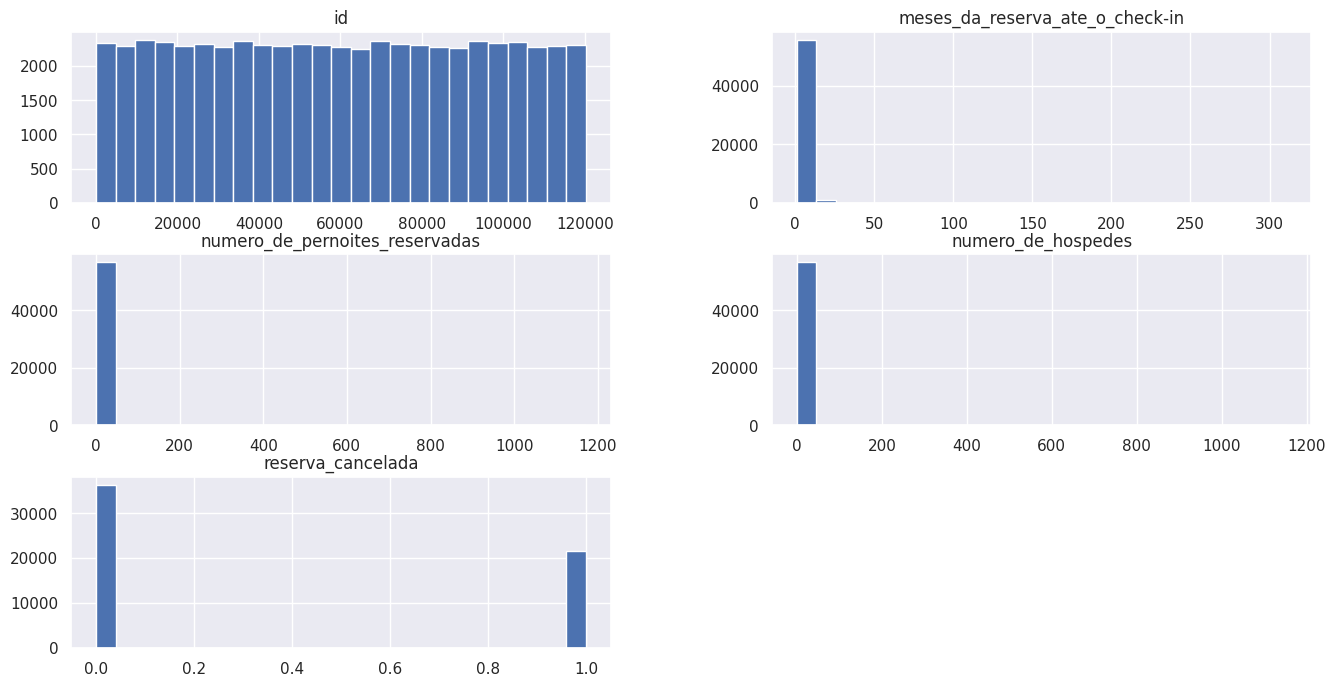

In [25]:
num_attributes.hist(bins=25, figsize=(16, 8));

#### 4.1.2 Variáveis Numéricas

#### 4.1.3 Variáveis Categóricas

In [26]:
# categorical_types = df4.select_dtypes(exclude=['int64', 'float64'])

# sns.countplot(x='regime_de_alimentacao', data=df4);

#### 4.1.4 Variável resposta

#### 4.2.1 Análise Multivariada

#### 4.2.1 Atributos Numéricos

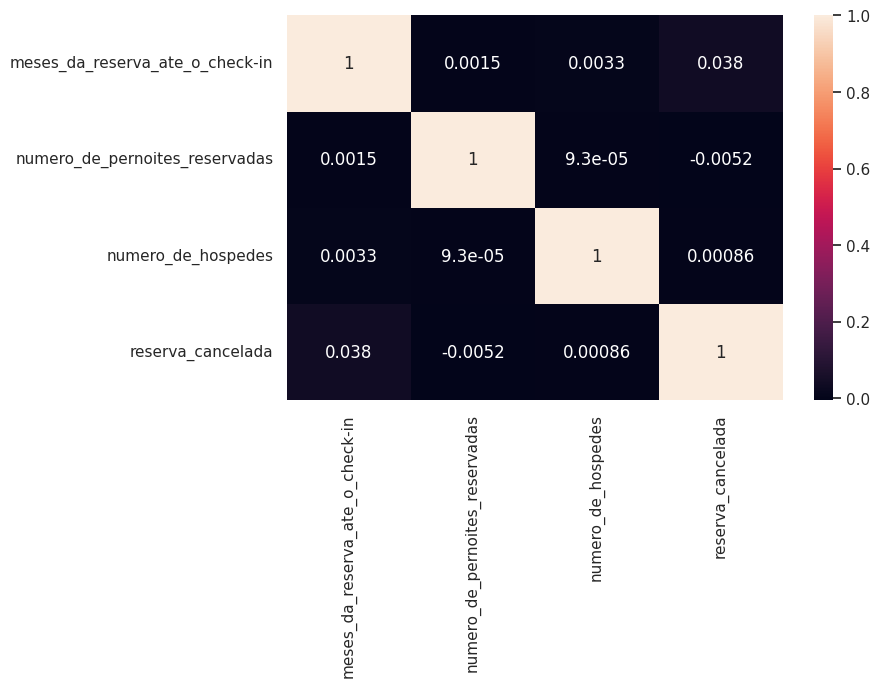

In [27]:
sns.set(rc={'figure.figsize':(8, 5)})

num_attributes = num_attributes.drop(['id'], axis=1)
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

#### 4.2.2 Atributos Categóricos

In [28]:
aux = df4.select_dtypes(include='object')
aux.sample(3)

,classificacao_do_hotel,regime_de_alimentacao,nacionalidade,forma_de_reserva,ja_se_hospedou_anterioremente,tipo_do_quarto_reservado,reserva_feita_por_agencia_de_turismo,reserva_feita_por_empresa,reserva_com_estacionamento,reserva_com_observacoes
18599,4 estrelas,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma
49010,4 estrelas,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,1 a 3
13862,5 estrelas,Café da manha,Spain,B2B,Não,Amethyst,Não,Sim,Sim,1 a 3


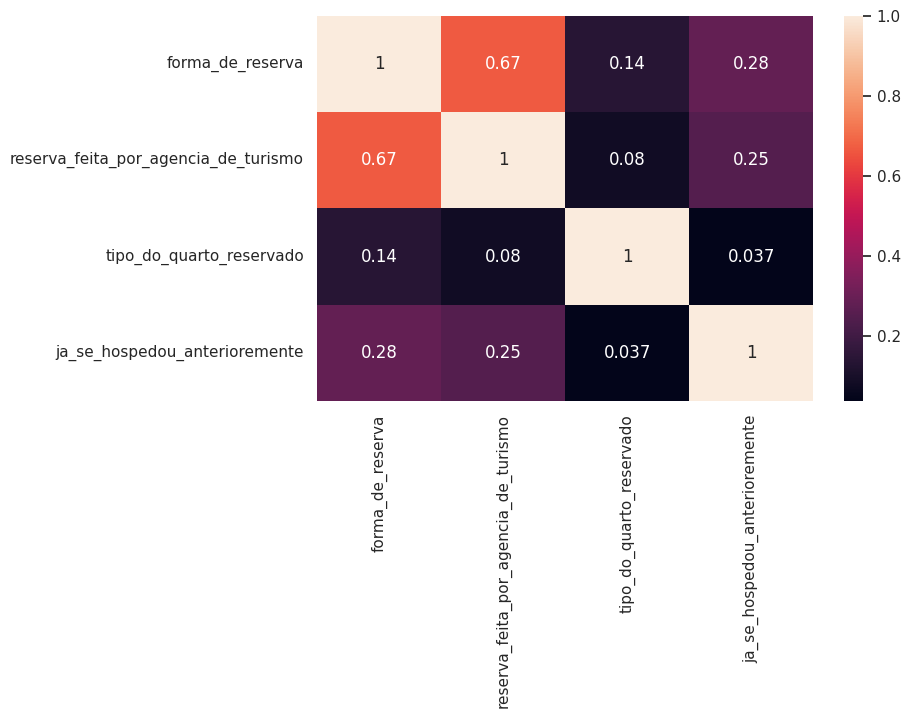

In [29]:
# Separação dos valores categóricos
aux = df4.select_dtypes(include='object')

# Aplicação da correlação categórica de Cramer's V
aux1 = cramers_v(aux['forma_de_reserva'], aux['forma_de_reserva'])
aux2 = cramers_v(aux['forma_de_reserva'], aux['reserva_feita_por_agencia_de_turismo'])
aux3 = cramers_v(aux['forma_de_reserva'], aux['tipo_do_quarto_reservado'])
aux4 = cramers_v(aux['forma_de_reserva'], aux['ja_se_hospedou_anterioremente'])

aux5 = cramers_v(aux['reserva_feita_por_agencia_de_turismo'], aux['forma_de_reserva'])
aux6 = cramers_v(aux['reserva_feita_por_agencia_de_turismo'], aux['reserva_feita_por_agencia_de_turismo'])
aux7 = cramers_v(aux['reserva_feita_por_agencia_de_turismo'], aux['tipo_do_quarto_reservado'])
aux8 = cramers_v(aux['reserva_feita_por_agencia_de_turismo'], aux['ja_se_hospedou_anterioremente'])

aux9 = cramers_v(aux['tipo_do_quarto_reservado'], aux['forma_de_reserva'])
aux10 = cramers_v(aux['tipo_do_quarto_reservado'], aux['reserva_feita_por_agencia_de_turismo'])
aux11 = cramers_v(aux['tipo_do_quarto_reservado'], aux['tipo_do_quarto_reservado'])
aux12 = cramers_v(aux['tipo_do_quarto_reservado'], aux['ja_se_hospedou_anterioremente'])

aux13 = cramers_v(aux['ja_se_hospedou_anterioremente'], aux['forma_de_reserva'])
aux14 = cramers_v(aux['ja_se_hospedou_anterioremente'], aux['reserva_feita_por_agencia_de_turismo'])
aux15 = cramers_v(aux['ja_se_hospedou_anterioremente'], aux['tipo_do_quarto_reservado'])
aux16 = cramers_v(aux['ja_se_hospedou_anterioremente'], aux['ja_se_hospedou_anterioremente'])



aux17 = pd.DataFrame({'forma_de_reserva': [aux1, aux2, aux3, aux4],
                      'reserva_feita_por_agencia_de_turismo': [aux5, aux6, aux7, aux8], 
                      'tipo_do_quarto_reservado': [aux9, aux10, aux11, aux12],
                      'ja_se_hospedou_anterioremente': [aux13, aux14, aux15, aux16]
                      })

aux17 = aux17.set_index(aux17.columns)

sns.heatmap(aux17, annot=True);

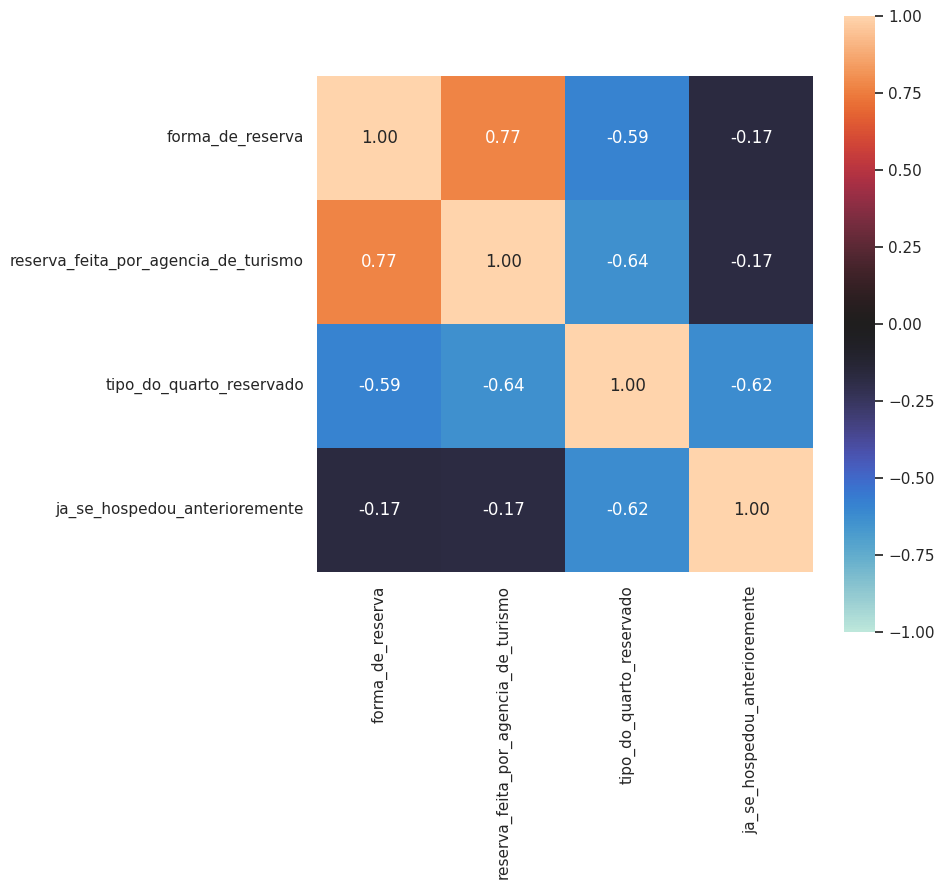

In [30]:
# Aplicação da correlação categórica de Theil's U (uncertainty coefficient)
associations(aux17, nom_nom_assoc='theil', figsize=(8, 8));

### 5.0 Preparação dos dados

In [31]:
df5 = df4.copy()

#### 5.1 Normalização

#### 5.2 Reescalonar (Rescaling)

#### 5.3 Transformação

#### 5.3.1 Encoding

In [32]:
df5.dtypes

id                                        int64
classificacao_do_hotel                   object
meses_da_reserva_ate_o_check-in           int64
numero_de_pernoites_reservadas            int64
numero_de_hospedes                      float64
regime_de_alimentacao                    object
nacionalidade                            object
forma_de_reserva                         object
ja_se_hospedou_anterioremente            object
tipo_do_quarto_reservado                 object
reserva_feita_por_agencia_de_turismo     object
reserva_feita_por_empresa                object
reserva_com_estacionamento               object
reserva_com_observacoes                  object
reserva_cancelada                         int64
classificacao_do_hotel_2                  int64
estrelas_quarto                         float64
indicador_qualidade_quarto              float64
combo_alimentacao                         int64
nights_per_hotel                        float64
dtype: object

In [33]:
categorical_types = df5.select_dtypes(exclude=['int64', 'float64'])
categorical_types.apply(lambda x: x.unique().shape[0])

classificacao_do_hotel                    2
regime_de_alimentacao                     4
nacionalidade                           166
forma_de_reserva                          3
ja_se_hospedou_anterioremente             2
tipo_do_quarto_reservado                 10
reserva_feita_por_agencia_de_turismo      2
reserva_feita_por_empresa                 2
reserva_com_estacionamento                2
reserva_com_observacoes                   3
dtype: int64

In [34]:
le = LabelEncoder()
te = target_encoder.TargetEncoder(handle_unknown='value')
mms = MinMaxScaler()
rs = RobustScaler()
st = StandardScaler()

# Rescaling de todos os valores Categóricos
df5['classificacao_do_hotel'] = le.fit_transform(df5['classificacao_do_hotel'])
x_test['classificacao_do_hotel'] = le.transform(x_test['classificacao_do_hotel'])
test_raw['classificacao_do_hotel'] = le.transform(test_raw['classificacao_do_hotel'])

df5['regime_de_alimentacao'] = le.fit_transform(df5['regime_de_alimentacao'])
x_test['regime_de_alimentacao'] = le.transform(x_test['regime_de_alimentacao'])
test_raw['regime_de_alimentacao'] = le.transform(test_raw['regime_de_alimentacao'])

df5['nacionalidade'] = te.fit_transform(df5['nacionalidade'], df5['reserva_cancelada'])
x_test['nacionalidade'] = te.transform(x_test['nacionalidade'])
test_raw['nacionalidade'] = te.transform(test_raw['nacionalidade'])

df5['forma_de_reserva'] = le.fit_transform(df5['forma_de_reserva'])
x_test['forma_de_reserva'] = le.transform(x_test['forma_de_reserva'])
test_raw['forma_de_reserva'] = le.transform(test_raw['forma_de_reserva'])

df5['ja_se_hospedou_anterioremente'] = le.fit_transform(df5['ja_se_hospedou_anterioremente'])
x_test['ja_se_hospedou_anterioremente'] = le.transform(x_test['ja_se_hospedou_anterioremente'])
test_raw['ja_se_hospedou_anterioremente'] = le.transform(test_raw['ja_se_hospedou_anterioremente'])

df5['tipo_do_quarto_reservado'] = le.fit_transform(df5['tipo_do_quarto_reservado'])
x_test['tipo_do_quarto_reservado'] = le.transform(x_test['tipo_do_quarto_reservado'])
test_raw['tipo_do_quarto_reservado'] = le.transform(test_raw['tipo_do_quarto_reservado'])

df5['reserva_feita_por_agencia_de_turismo'] = le.fit_transform(df5['reserva_feita_por_agencia_de_turismo'])
x_test['reserva_feita_por_agencia_de_turismo'] = le.transform(x_test['reserva_feita_por_agencia_de_turismo'])
test_raw['reserva_feita_por_agencia_de_turismo'] = le.transform(test_raw['reserva_feita_por_agencia_de_turismo'])

df5['reserva_feita_por_empresa'] = le.fit_transform(df5['reserva_feita_por_empresa'])
x_test['reserva_feita_por_empresa'] = le.transform(x_test['reserva_feita_por_empresa'])
test_raw['reserva_feita_por_empresa'] = le.transform(test_raw['reserva_feita_por_empresa'])

df5['reserva_com_estacionamento'] = le.fit_transform(df5['reserva_com_estacionamento'])
x_test['reserva_com_estacionamento'] = le.transform(x_test['reserva_com_estacionamento'])
test_raw['reserva_com_estacionamento'] = le.transform(test_raw['reserva_com_estacionamento'])

df5['reserva_com_observacoes'] = le.fit_transform(df5['reserva_com_observacoes'])
x_test['reserva_com_observacoes'] = le.transform(x_test['reserva_com_observacoes'])
test_raw['reserva_com_observacoes'] = le.transform(test_raw['reserva_com_observacoes'])

In [35]:
# Rescaling dos valores numéricos

df5['meses_da_reserva_ate_o_check-in'] = rs.fit_transform(df5[['meses_da_reserva_ate_o_check-in']].values)
x_test['meses_da_reserva_ate_o_check-in'] = rs.transform(x_test[['meses_da_reserva_ate_o_check-in']].values)
test_raw['meses_da_reserva_ate_o_check-in'] = rs.transform(test_raw[['meses_da_reserva_ate_o_check-in']].values)

df5['numero_de_pernoites_reservadas'] = rs.fit_transform(df5[['numero_de_pernoites_reservadas']].values)
x_test['numero_de_pernoites_reservadas'] = rs.transform(x_test[['numero_de_pernoites_reservadas']].values)
test_raw['numero_de_pernoites_reservadas'] = rs.transform(test_raw[['numero_de_pernoites_reservadas']].values)

### 6.0 Seleção dos Atributos

In [36]:
df6 = df5.copy()

#### 6.1 Separação dos Dados para Treino e Teste

#### 6.1 Escolha das Colunas / Atributos

### 7.0 Modelagem de Machine Learning

In [37]:
df7 = df6.copy()

X = df7.drop('reserva_cancelada', axis=1)
y = df7['reserva_cancelada'].copy()

#### 7.1 Modelo Random Forest Classifier

In [38]:
rfc_model = en.RandomForestClassifier(random_state=42)

rfc_model.fit(X, y)

y_hat_rf = rfc_model.predict(x_test)

rfc_result = metrics.f1_score(y_test, y_hat_rf)
rfc_result

0.9616508056157542

#### 7.2 Modelo Extra Trees Classifier

In [39]:
etc_model = en.ExtraTreesClassifier(random_state=42)

etc_model.fit(X, y)

y_hat_et = etc_model.predict(x_test)

etc_result = metrics.f1_score(y_test, y_hat_et)

#### 7.3 Modelo XGBoost

In [40]:
xgb_model = XGBClassifier(random_state=42)

xgb_model.fit(X, y)

y_hat_xgb = xgb_model.predict(x_test)

xgb_result = metrics.f1_score(y_test, y_hat_xgb)

#### 7.4 Modelo LGBM

In [41]:
lgbm_model = LGBMClassifier(random_state=42)

lgbm_model.fit(X, y)

y_hat_lgbm = lgbm_model.predict(x_test)

lgbm_result = metrics.f1_score(y_test, y_hat_lgbm)

#### 7.5 Modelo KNN

In [42]:
knn_model = KNeighborsClassifier() 

knn_model.fit(X, y)

y_hat_knn = knn_model.predict(x_test)

knn_result = metrics.f1_score(y_test, y_hat_knn)

#### 7.6 Modelo Decision Tree Classifier

In [43]:
dtc_model = DecisionTreeClassifier()

dtc_model.fit(X, y)

y_hat_dtc = dtc_model.predict(x_test)

dtc_result = metrics.f1_score(y_test, y_hat_dtc)

#### 7.7 Avaliação dos Modelos

In [44]:
results = pd.DataFrame([rfc_result, etc_result, xgb_result, lgbm_result, knn_result, dtc_result], index=['RFC', 'ETC', 'XGB', 'LGBM', 'KNN', 'DTC'])
results.columns = ['Resultado']
results.sort_values(by='Resultado', ascending=False)

,Resultado
RFC,0.961651
XGB,0.960795
LGBM,0.955619
DTC,0.953285
ETC,0.953143
KNN,0.923179


#### 7.8 Ensembles

In [45]:
# rf_model = en.RandomForestClassifier(n_estimators=502, random_state=42)
# lr_clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
# xgb_model = XGBClassifier(random_state=42, n_jobs=-1)
# gnb_model = GaussianNB()


# voting_clf = VotingClassifier(
#     estimators=[('random_forest', rf_model), ('logistic_regression', lr_clf), ('xgboost', xgb_model), ('gaussNB', gnb_model)],
#     voting='soft', # 'soft' usa probabilidades para votação, enquanto 'hard' usa rótulos
#     weights=[2, 1, 2, 1], # Pode ser usado para ponderar a importância de cada classificador, como [2, 1,...]
#     n_jobs=-1)

# voting_clf.fit(X, y)

# y_pred_vot = voting_clf.predict(x_test)

# metrics.f1_score(y_test, y_pred_vot, average='macro')

In [46]:
rf_model = en.RandomForestClassifier(n_estimators=502, random_state=42, n_jobs=-1)
lr_clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, n_jobs=-1)
xgb_model = XGBClassifier(n_estimators=502, random_state=42, n_jobs=-1)
lgbm_model = LGBMClassifier(n_estimators=502, random_state=42, n_jobs=-1)
et_model = en.ExtraTreesClassifier(n_estimators=502, random_state=42, n_jobs=-1)
knn_clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
ada_clf = AdaBoostClassifier(n_estimators=502, random_state=42)
gnb_model = GaussianNB()


voting_clf = VotingClassifier(
    estimators=[('random_forest', rf_model), ('logistic_regression', lr_clf), ('xgboost', xgb_model),
                ('extra_tree', et_model), ('lgbm', lgbm_model), ('knn', knn_clf), ('ada', ada_clf), ('gaussNB', gnb_model)],
    voting='soft', # 'soft' usa probabilidades para votação, enquanto 'hard' usa rótulos
    weights=[2, 1, 2, 1, 1, 1, 1, 1], # Pode ser usado para ponderar a importância de cada classificador, como [2, 1, 3, ...]
    n_jobs=-1)

voting_clf.fit(X, y)

y_pred_vot = voting_clf.predict(x_test)

metrics.f1_score(y_test, y_pred_vot, average='macro')

0.9731184748459742

### 8.0 Ajuste do Modelo (Hyperparameter Fine Tuning)

In [47]:
df8 = df7.copy()

#### 8.1 Busca Aleatória (Random Search)

In [48]:
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# param_grid = {'n_estimators': [25, 50, 100, 150],
# 	          'max_features': ['sqrt', 'log2', None],
# 	          'max_depth': [3, 6, 9],
# 	          'max_leaf_nodes': [3, 6, 9]}

# grid_search = GridSearchCV(RandomForestClassifier(),
#                            param_grid=param_grid)

# grid_search.fit(X, y)
# print(grid_search.best_estimator_)


In [49]:
# random_search = RandomizedSearchCV(RandomForestClassifier(),
#                                    param_grid)

# random_search.fit(X, y)
# print(random_search.best_estimator_)

#### 8.2 Modelo Final

In [50]:
# # RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9, n_estimators=50)

# rf_model = en.RandomForestClassifier(max_depth=6, 
#                                      max_features=None, 
#                                      max_leaf_nodes=9, 
#                                      n_estimators=50)

# rf_model.fit(X, y)

# y_hat_rf = rf_model.predict(x_test)

# rfc_result = metrics.f1_score(y_test, y_hat_rf)
rfc_result

0.9616508056157542

### 9.0 Submissão

In [51]:
df9 = df8.copy()

In [52]:
y_hat = voting_clf.predict(test_raw)

In [53]:
submission = pd.concat([test_raw, pd.Series(y_hat)], axis=1).rename(columns={0: 'Reserva Cancelada'})

submission[['id', 'Reserva Cancelada']].to_csv('submission/submit20.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:###5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1f2e6561-5818-46b0-8797-0a88d12bf58e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>